In [23]:
# 添加库函数
import os
import torch
import torch.nn as nn
import math
import torch.optim as optim
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)
from pytorch3d.vis.plotly_vis import plot_batch_individually
from pytorch3d.ops.points_normals import estimate_pointcloud_normals
from pytorch3d.ops.mesh_face_areas_normals import mesh_face_areas_normals
from torch.autograd import gradcheck

def gaussian_pdf(x, mu, sigma):
    const = 1.0
    exp = torch.exp(-0.5 * ((x - mu) / sigma)**2)
    return const * exp

class ISAR_render(nn.Module):
    def __init__(self, device) -> None:
        super().__init__()
        self.c = torch.tensor([299792458.0], device=device)
        self.Tcoh = torch.tensor([10.0*16], device=device)
        self.PRF = torch.tensor([20.0], device=device)
        self.fc = torch.tensor([9.7e9], device=device)
        self.Tp = torch.tensor([5e-4], device=device)
        self.B = torch.tensor([30e7*16], device=device)
        self.Range_map,self.Dopple_map = torch.meshgrid(torch.linspace(-10,10,124).to(device),torch.linspace(-3,3,145).to(device), indexing='xy')
        self.lambda1 = self.c/self.fc
        self.RangeRes = self.c/self.B/2
        self.complex_i = torch.tensor([1j], dtype=torch.complex64, device=device)

    def forward(self, mesh, RadarLos, SpinAxis, Omega):
        # 输入
        # mesh为pytorch3d自带的结构，采样后采样点为：sampled_points [batchsize,N,3] point_normals [batchsize,N,3]
        # 雷达视线方向 RadarLos [batchsize,3]
        # 转轴 SpinAxis [batchsize,3]
        sampled_points,point_normals = sample_points_from_meshes(mesh, 8000, return_normals=True)
        DopplerAxis = torch.cross(RadarLos,SpinAxis,dim = -1)
        point_vel = torch.cross(SpinAxis.unsqueeze(1),sampled_points,dim = -1)
        point_vel_Radial = Omega * torch.sum(RadarLos.unsqueeze(1)*point_vel,dim=2)
        point_doppler = -2*point_vel_Radial/self.lambda1
        point_range = torch.sum(RadarLos.unsqueeze(1)*sampled_points,dim=2)
        point_Amp = -4*torch.sum(RadarLos.unsqueeze(1)*point_normals, dim=2)
        point_Amp = point_Amp
        point_Amp = torch.clamp(point_Amp,min=0.0,max=1.0)
        DopplerRes = self.lambda1/2/Omega/self.Tcoh

        # range_idx = torch.round
        
        # image_AllPoint = torch.sinc(1/self.RangeRes*(self.Range_map.unsqueeze(0).unsqueeze(1)-point_range.unsqueeze(2).unsqueeze(3))) * torch.sinc(1/DopplerRes*(self.Dopple_map.unsqueeze(0).unsqueeze(1)-point_doppler.unsqueeze(2).unsqueeze(3))) * torch.exp(-4*math.pi*self.complex_i/self.lambda1*point_range.unsqueeze(2).unsqueeze(3))
        # image_AllPoint = point_Amp.unsqueeze(2).unsqueeze(3)*torch.sinc(1/self.RangeRes*(self.Range_map.unsqueeze(0).unsqueeze(1)-point_range.unsqueeze(2).unsqueeze(3))) * torch.sinc(1/DopplerRes*(self.Dopple_map.unsqueeze(0).unsqueeze(1)-point_doppler.unsqueeze(2).unsqueeze(3))) * torch.exp(-4*math.pi*self.complex_i/self.lambda1*point_range.unsqueeze(2).unsqueeze(3))
        # # image_AllPoint = torch.abs(point_Amp.unsqueeze(2).unsqueeze(3)*torch.sinc(1/self.RangeRes*(self.Range_map.unsqueeze(0).unsqueeze(1)-point_range.unsqueeze(2).unsqueeze(3))) * torch.sinc(1/DopplerRes*(self.Dopple_map.unsqueeze(0).unsqueeze(1)-point_doppler.unsqueeze(2).unsqueeze(3))) * torch.exp(-4*math.pi*self.complex_i/self.lambda1*point_range.unsqueeze(2).unsqueeze(3)))
        image_AllPoint = point_Amp.unsqueeze(2).unsqueeze(3)*gaussian_pdf(point_range.unsqueeze(2).unsqueeze(3), self.Range_map.unsqueeze(0).unsqueeze(1), self.RangeRes) * gaussian_pdf(point_doppler.unsqueeze(2).unsqueeze(3), self.Dopple_map.unsqueeze(0).unsqueeze(1), DopplerRes)
        image = torch.sum(image_AllPoint,dim=1)

        return image

def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(90, 0)
    ax.axis('equal')
    plt.show()

import os

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:2")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

    


In [24]:
# 整体放缩系数
scale_all = 0.05

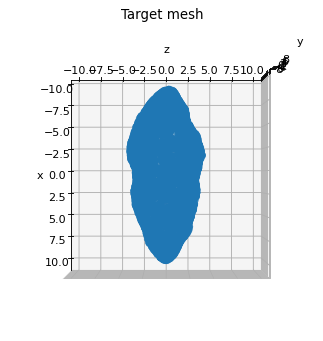

In [25]:
# 载入一个模型
trg_obj = 'Geographos Radar-based, low-res(1).obj'
# trg_obj = 'dolphin.obj'
# trg_obj = 'wx_origin.obj'
# 读取卫星各项参数
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale *10

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])


# 为mesh添加材质信息
verts_rgb = torch.ones_like(trg_mesh.verts_packed())*255  # 使用纯白色作为默认颜色
verts_rgb = verts_rgb.unsqueeze(0)
textures = TexturesVertex(verts_features=verts_rgb)
trg_mesh.textures = textures

src_mesh = trg_mesh

# 可视化src_mesh
plot_pointcloud(src_mesh, title="Target mesh")

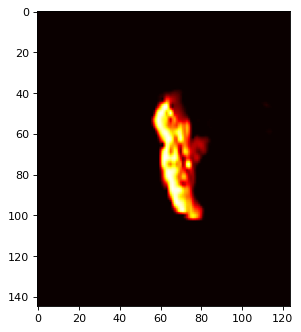

In [26]:
# # 创建初始模型，球形
# sphere1 = ico_sphere(4, device)
# sphere2 = ico_sphere(4, device)

# # 平移第二个球体，使它与第一个球体黏连
# # 获取第一个球体的最大 x 坐标
# max_x = sphere1.verts_packed()[:, 0].max()

# # 获取第二个球体的顶点并进行x方向平移
# shift = max_x - 0.1  # 确保轻微重叠
# verts2 = sphere2.verts_packed() + torch.tensor([shift, 0, 0], device=device)

# # 获取第一个球体的顶点并且平移
# verts1 = sphere2.verts_packed() + torch.tensor([-shift, 0, 0], device=device)

# # 合并两球体的顶点
# verts = torch.cat([verts1, verts2], dim=0)

# # 将两球质点平移
# verts = verts + torch.tensor([0, -1, 0], device=device)

# # 合并面片，并更新第二个球体的面片索引
# faces1 = sphere1.faces_packed()
# faces2 = sphere2.faces_packed() + sphere1.verts_packed().shape[0]  # 更新索引

# # 合并面片数据
# faces = torch.cat([faces1, faces2], dim=0)

# # 创建黏连的球体网格
# src_mesh = Meshes(verts=[verts], faces=[faces])


# verts = src_mesh.verts_packed()
# faces = src_mesh.faces_packed()
# scaled_verts = verts * 2

# src_mesh = Meshes(verts=[scaled_verts], faces=[faces])

# # 绘制初始情况下的src_mesh
# plot_pointcloud(src_mesh, "Source mesh")


# 创建渲染器
ISAR_render1 = ISAR_render(device)

# 输入数据
image_batch = np.load('./2024wb_peizhun/2024wb.npz')
image_input = image_batch['image_batch']
image_trg = np.abs(image_input)

plt.imshow(image_trg[0,:,:],cmap='hot')
image_trg = torch.tensor([image_trg],device=device)
image_trg = image_trg.squeeze(0)
# 数据归一化
max_values, _ = torch.max(image_trg, dim=2)
max_values_dim1, _ = torch.max(max_values, dim=1)
image_trg = image_trg/max_values_dim1.unsqueeze(1).unsqueeze(2)

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:2')
tensor([[-8.7423e-08,  1.0000e+00,  0.0000e+00],
        [ 8.7156e-02,  9.9619e-01,  0.0000e+00],
        [ 1.7365e-01,  9.8481e-01,  0.0000e+00],
        [ 2.5882e-01,  9.6593e-01,  0.0000e+00],
        [ 3.4202e-01,  9.3969e-01,  0.0000e+00],
        [ 4.2262e-01,  9.0631e-01,  0.0000e+00],
        [ 5.0000e-01,  8.6603e-01,  0.0000e+00],
        [ 5.7358e-01,  8.1915e-01,  0.0000e+00],
        [ 6.4279e-01,  7.6604e-01,  0.0000e+00],
        [ 7.0711e-01,  7.0711e-01,  0.0000e+00]], device='cuda:2')
torch.Size([10, 3])


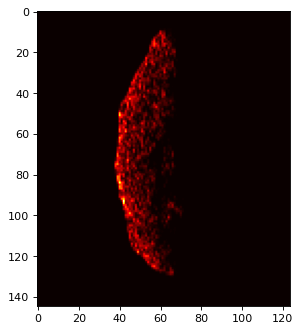

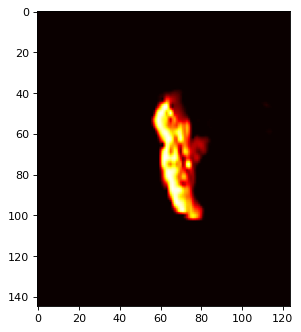

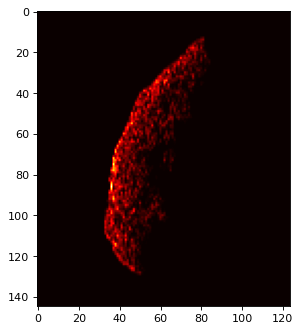

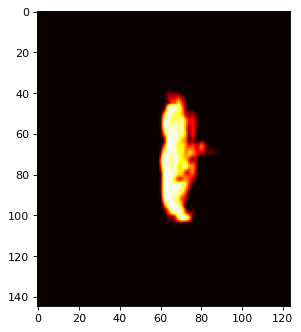

<Figure size 512x384 with 0 Axes>

In [31]:
# 生成25组雷达视线方向
def vec_rot(vec,axis_x,axis_y,axis_z,theta):

    axis_x = axis_x.expand(theta.shape)
    axis_y = axis_y.expand(theta.shape)
    axis_z = axis_z.expand(theta.shape)

    c = torch.cos(theta)
    s = torch.sin(theta)
    one_c = 1 - c

    Rotmat = torch.stack([
        torch.stack([axis_x**2 * one_c + c, axis_x * axis_y * one_c - axis_z * s, axis_x * axis_z * one_c + axis_y * s], dim=-1),
        torch.stack([axis_x * axis_y * one_c + axis_z * s, axis_y**2 * one_c + c, axis_y * axis_z * one_c - axis_x * s], dim=-1),
        torch.stack([axis_x * axis_z * one_c - axis_y * s, axis_y * axis_z * one_c + axis_x * s, axis_z**2 * one_c + c], dim=-1)
    ], dim=-2)

    vec_rot = torch.matmul(Rotmat,vec.unsqueeze(1)).squeeze(2)

    return vec_rot

SpinAxis = torch.tensor([0,0,1.0], device=device)
Omega = torch.tensor([0.004532090125293*0.9], device=device)
SpinAxis = SpinAxis.unsqueeze(0)
Omega = Omega.unsqueeze(0)

batch = 10

RadarLos = torch.tensor([0,-1.0,0], device=device)
# RadarLos = torch.tensor([-1/2,0,-math.sqrt(3)/2], device=device)
theta = torch.linspace(math.pi,math.pi*3/4,batch).to(device)

axis_x = torch.tensor([0.0], device=device)
axis_y = torch.tensor([0.0], device=device)
axis_z = torch.tensor([1.0], device=device)
omega_vec = torch.stack((axis_x.repeat(batch),axis_y.repeat(batch),axis_z.repeat(batch)),dim = 1)
print(omega_vec)
Round_radar_los = vec_rot(RadarLos,axis_x,axis_y,axis_z,theta)
Round_radar_los_real = vec_rot(RadarLos,axis_x,axis_y,axis_z,-theta)

print(Round_radar_los)
print(Round_radar_los.shape)

image_src = ISAR_render1(src_mesh, Round_radar_los, SpinAxis, Omega)
# 取模归一化
image_src = torch.abs(image_src)
max1,_ = torch.max(image_src,dim=2)
max2,_ = torch.max(max1,dim=1)
image_src = image_src/max2.unsqueeze(1).unsqueeze(2)
plt.figure()
plt.imshow(image_src[0,:,:].detach().cpu(),cmap='hot')
plt.figure()
plt.imshow(image_trg[0,:,:].detach().cpu(),cmap='hot')
plt.figure()
plt.imshow(image_src[4,:,:].detach().cpu(),cmap='hot')
plt.figure()
plt.imshow(image_trg[4,:,:].detach().cpu(),cmap='hot')
plt.figure()
# plt.imshow(image_src[10,:,:].detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image_trg[10,:,:].detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image_src[15,:,:].detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image_trg[15,:,:].detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image_src[20,:,:].detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image_trg[20,:,:].detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image_src[24,:,:].detach().cpu(),cmap='hot')
# plt.figure()
# plt.imshow(image_trg[24,:,:].detach().cpu(),cmap='hot')
# plt.colorbar()

# 将图片转换为numpy,并保存为png文件
image_max = image_src.max().detach().cpu().numpy()
# print(image_max)
image_min = image_src.min().detach().cpu().numpy()
# 创建文件夹
os.makedirs("./1620_point",exist_ok=True)
import cv2
import numpy as np
for i in range(0,10):
    image_i = image_src[i,:,:].squeeze(0).detach().cpu().numpy()
    image_i = (image_i - image_min)/(image_max-image_min)
    LOS_real = Round_radar_los_real[i].detach().cpu().numpy()
    rotation_axis = omega_vec[i].detach().cpu().numpy()
    np.savez("./1620_point/image"+str(i)+".npz", image=image_i, LOS = LOS_real, rotation_axis = rotation_axis)
    image_i = np.uint8(image_i*255)
    cv2.imwrite("./1620_point/image"+str(i)+".png",image_i)

In [6]:
# # 生成36组雷达视线方向
# def vec_rot(vec,axis_x,axis_y,axis_z,theta):

#     axis_x = axis_x.expand(theta.shape)
#     axis_y = axis_y.expand(theta.shape)
#     axis_z = axis_z.expand(theta.shape)

#     c = torch.cos(theta)
#     s = torch.sin(theta)
#     one_c = 1 - c

#     Rotmat = torch.stack([
#         torch.stack([axis_x**2 * one_c + c, axis_x * axis_y * one_c - axis_z * s, axis_x * axis_z * one_c + axis_y * s], dim=-1),
#         torch.stack([axis_x * axis_y * one_c + axis_z * s, axis_y**2 * one_c + c, axis_y * axis_z * one_c - axis_x * s], dim=-1),
#         torch.stack([axis_x * axis_z * one_c - axis_y * s, axis_y * axis_z * one_c + axis_x * s, axis_z**2 * one_c + c], dim=-1)
#     ], dim=-2)

#     vec_rot = torch.matmul(Rotmat,vec.unsqueeze(1)).squeeze(2)

#     return vec_rot

# batch = 12

# RadarLos1 = torch.tensor([-1.0,0,0], device=device)
# RadarLos2 = torch.tensor([-1/2,0,-math.sqrt(3)/2], device=device)
# RadarLos3 = torch.tensor([-1/2,0,math.sqrt(3)/2], device=device)
# theta = torch.linspace(0,2*math.pi,batch).to(device)

# axis_x = torch.tensor([0.0], device=device)
# axis_y = torch.tensor([0.0], device=device)
# axis_z = torch.tensor([1.0], device=device)
# Round_radar_los1 = vec_rot(RadarLos1,axis_x,axis_y,axis_z,theta)
# Round_radar_los2 = vec_rot(RadarLos2,axis_x,axis_y,axis_z,theta)
# Round_radar_los3 = vec_rot(RadarLos3,axis_x,axis_y,axis_z,theta)

# Round_radar_los = torch.cat([Round_radar_los1,Round_radar_los2,Round_radar_los3],dim=-2)
# print(Round_radar_los)
# print(Round_radar_los.shape)

In [7]:
# SpinAxis = torch.tensor([0,0,1.0], device=device)
# Omega = torch.tensor([2*math.pi/3600/6], device=device)
# SpinAxis = SpinAxis.unsqueeze(0)
# Omega = Omega.unsqueeze(0)

In [8]:
# def points_normal_visual(points,normals):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
#     x_normal, y_normal, z_normal = normals.clone().detach().cpu().squeeze().unbind(1)
#     # 绘制点云
#     ax.scatter(x, y, z, color='b', marker='o', alpha=0.5)

#     # 绘制法向量
#     # 此处通过 quiver 函数, scale=10 调整法向量的长度
#     ax.quiver(
#         x, y, z,
#         x_normal, y_normal, z_normal,
#         length=1, color='r', normalize=True
#     )

#     # 设置坐标轴标签
#     ax.set_xlabel('X Axis')
#     ax.set_ylabel('Y Axis')
#     ax.set_zlabel('Z Axis')

#     # 设置标题
#     ax.set_title('Point Cloud and Normals')
#     ax.view_init(40, 30)
#     # 显示图形
#     plt.show()

# deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

# sampled_points_src, point_normals_src= sample_points_from_meshes(src_mesh, 2000,return_normals = True)
# points_normal_opt = torch.tensor(point_normals_src,requires_grad=True)

# optimizer = torch.optim.Adam([deform_verts,points_normal_opt], lr=0.01)

# points_normal_visual(sampled_points_src,points_normal_opt)

# image_src = ISAR_render1(src_mesh, Round_radar_los[0:3,:], SpinAxis, Omega)

# image_src = torch.abs(image_src)
# max1,_ = torch.max(image_src,dim=2)
# max2,_ = torch.max(max1,dim=1)
# image_src = image_src/max2.unsqueeze(1).unsqueeze(2)

# plt.figure()
# plt.imshow(image_src[0,:,:].detach().cpu(),cmap='hot')
# plt.colorbar()

  0%|          | 0/4000 [00:00<?, ?it/s]

/root/anaconda3/envs/3d_env/lib/python3.10/site-packages/pytorch3d/ops/laplacian_matrices.py:51: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/torch/csrc/utils/tensor_new.cpp:618.)
  A = torch.sparse.FloatTensor(idx, ones, (V, V))


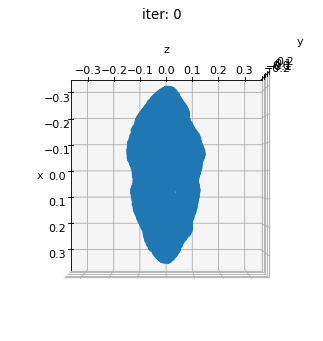

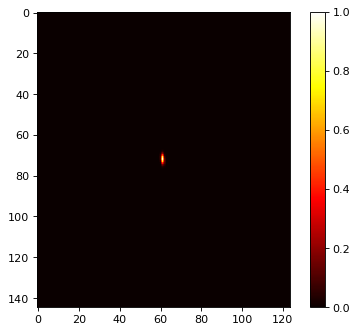

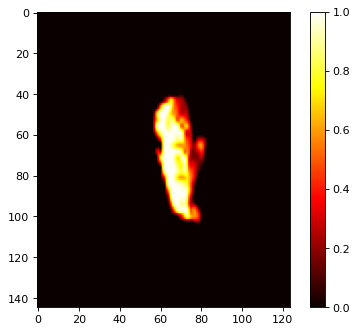

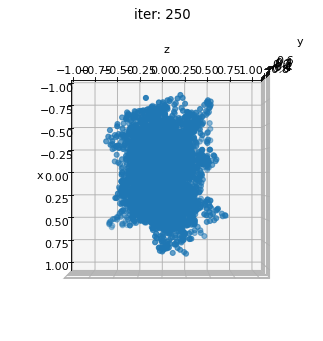

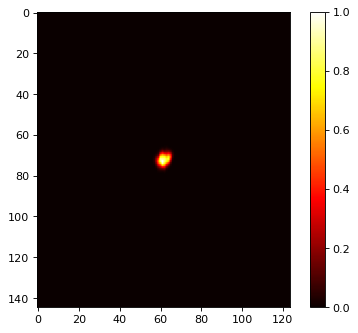

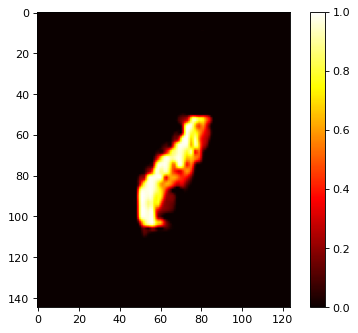

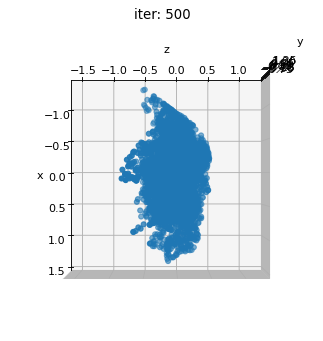

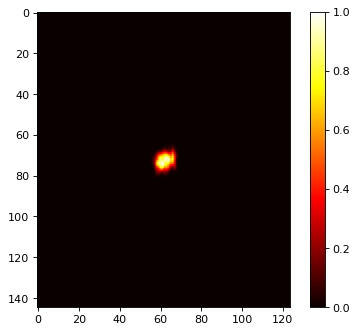

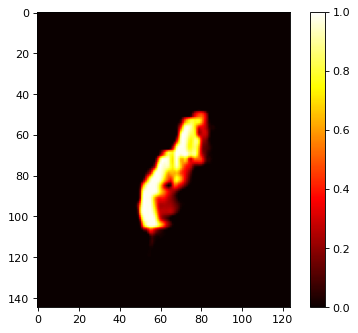

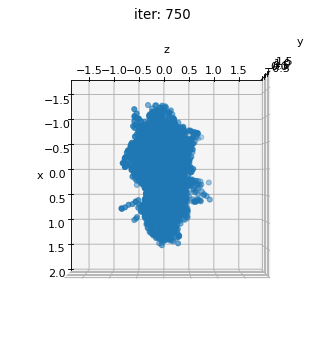

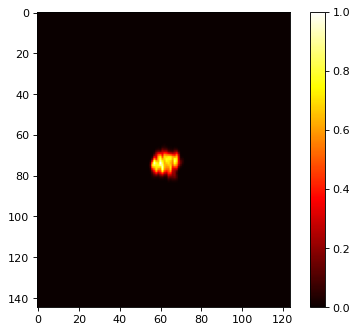

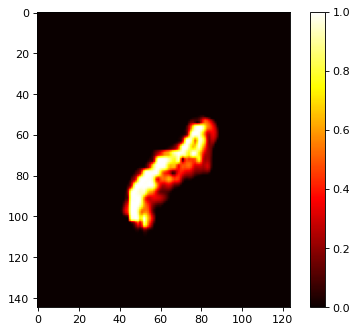

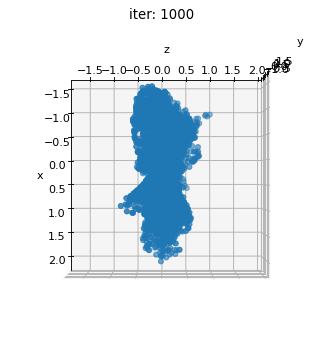

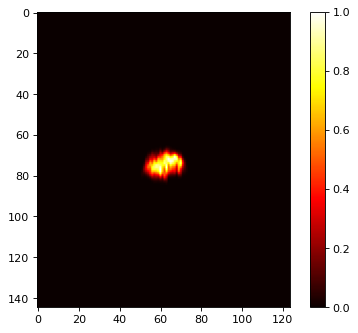

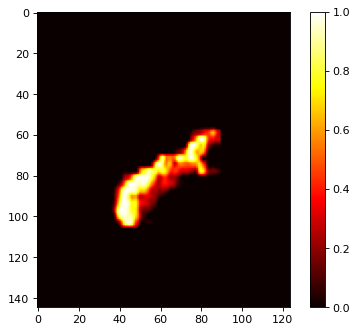

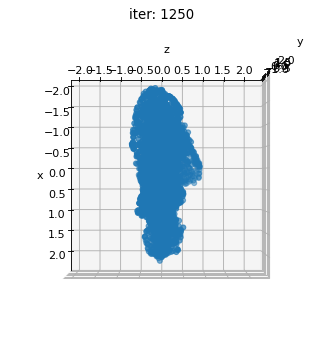

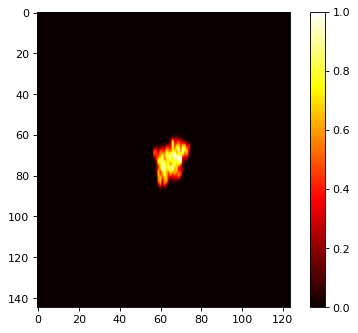

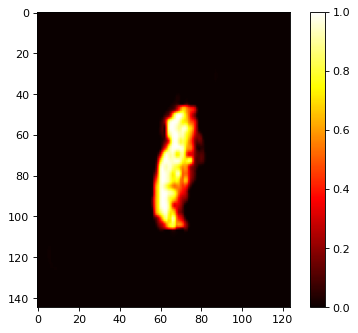

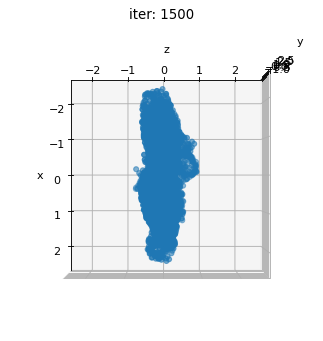

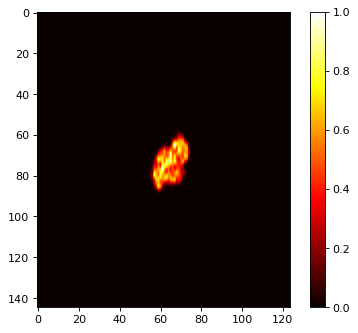

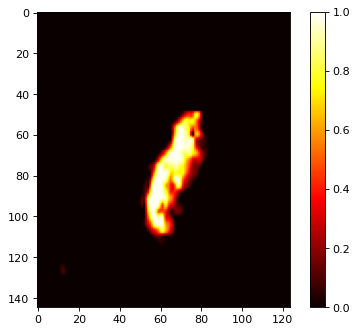

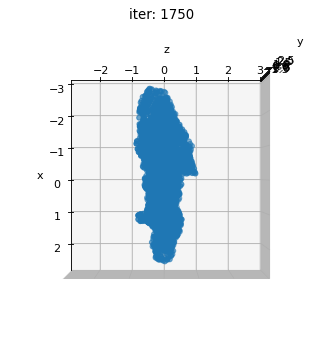

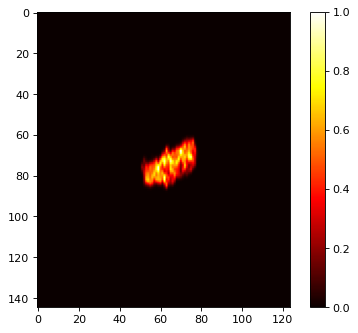

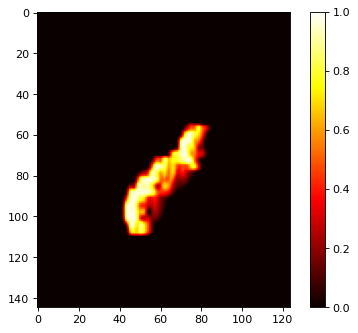

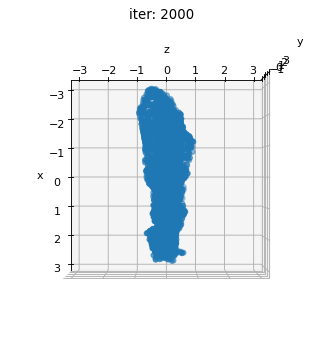

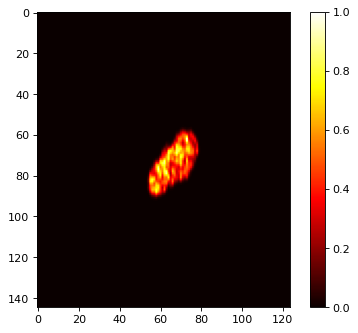

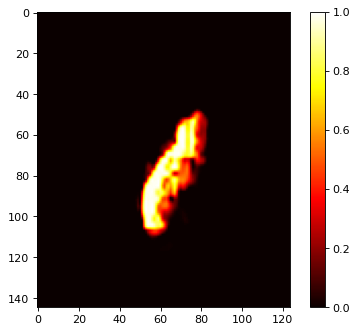

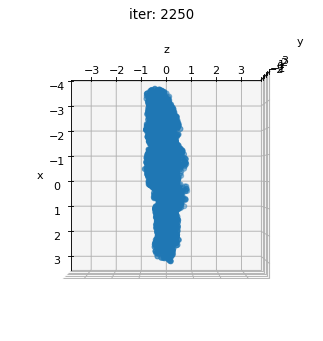

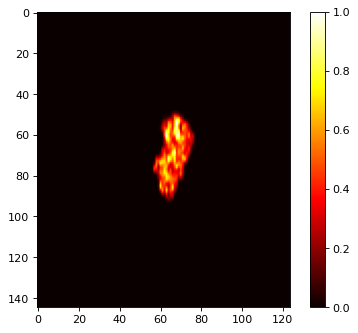

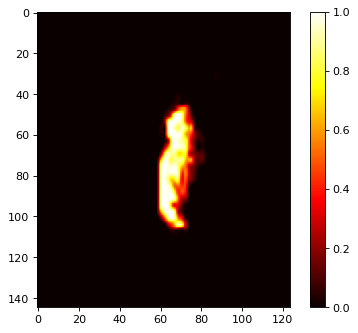

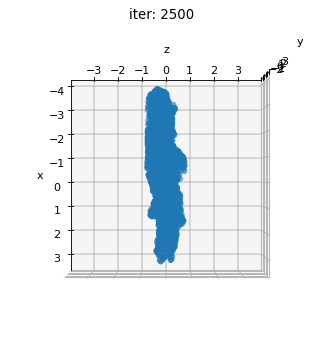

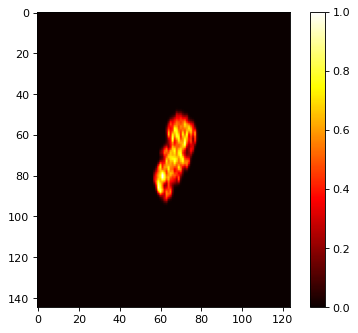

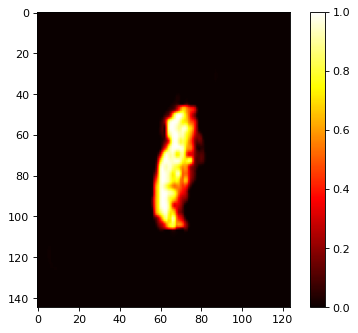

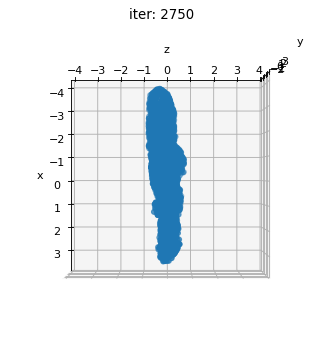

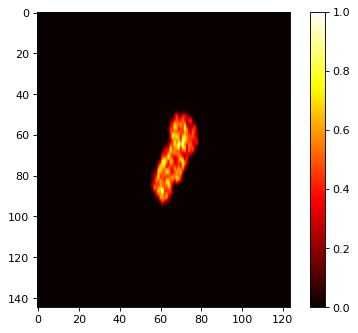

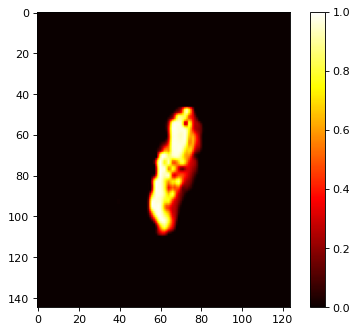

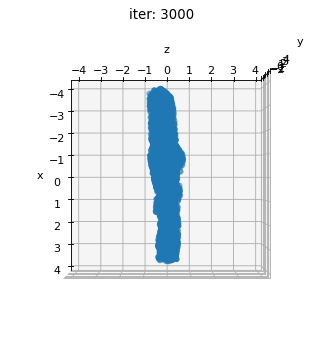

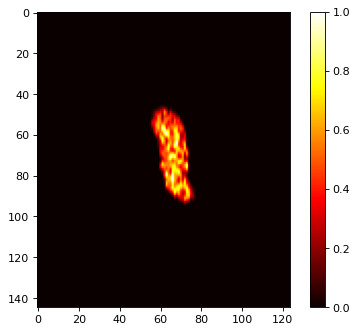

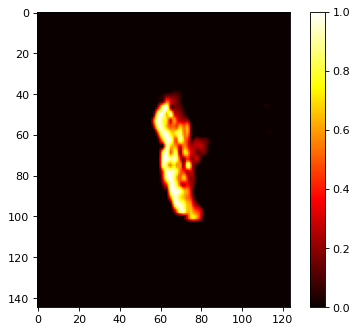

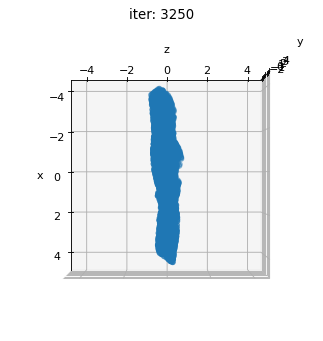

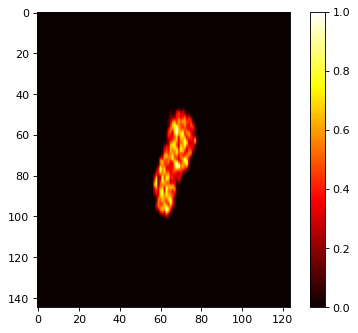

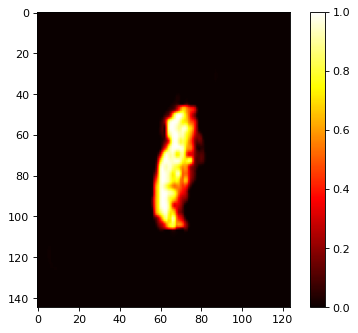

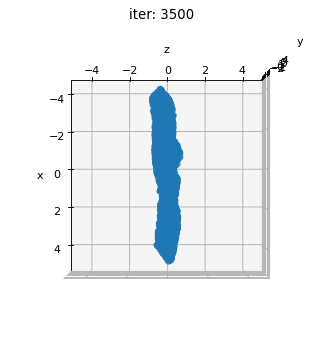

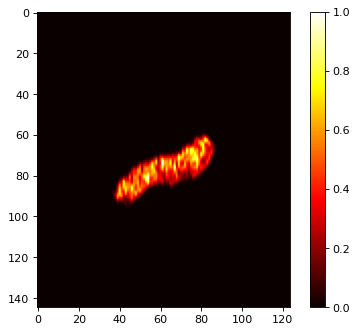

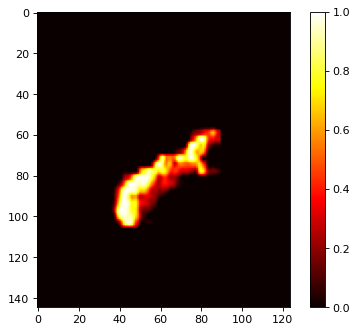

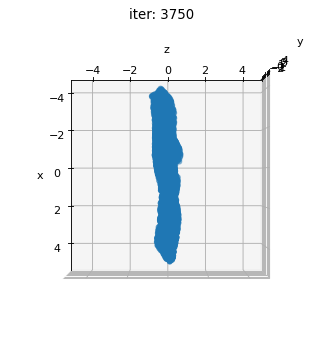

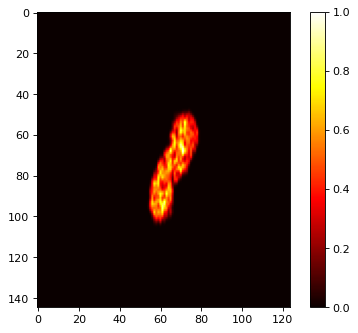

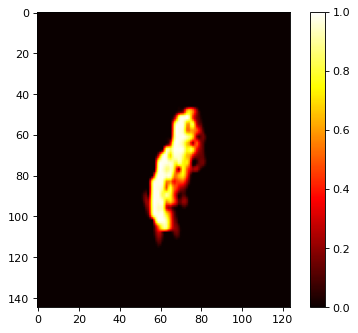

In [9]:
deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)

optimizer = torch.optim.Adam([deform_verts], lr=0.05)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=4000,eta_min=5e-4)


# Number of optimization steps
Niter = 4000
# Weight for the image loss
w_image = 0.0005
# Weight for mesh edge loss
w_edge = 3
# Weight for mesh normal consistency
w_normal = 3
# Weight for mesh laplacian smoothing
w_laplacian = 3
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))

image_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # 每轮选取三个视角进行训练
    random_numbers = np.random.choice(range(0, 25), 6, replace=False)
    image_src = ISAR_render1(new_src_mesh, Round_radar_los[random_numbers,:], SpinAxis, Omega)
    # 取模归一化
    image_src = torch.abs(image_src)
    max1,_ = torch.max(image_src,dim=2)
    max2,_ = torch.max(max1,dim=1)
    image_src = image_src/max2.unsqueeze(1).unsqueeze(2)
    image_trg_sample = image_trg[random_numbers,:,:]
    
    # 计算简单的mse
    loss_image = torch.sum((image_trg_sample - image_src)**2)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_image * w_image + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    image_losses.append(float(loss_image.detach().cpu()))
    edge_losses.append(float(loss_edge.detach().cpu()))
    normal_losses.append(float(loss_normal.detach().cpu()))
    laplacian_losses.append(float(loss_laplacian.detach().cpu()))
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        plt.figure()
        plt.imshow(image_src[0,:,:].detach().cpu(),cmap='hot')
        plt.colorbar()
        plt.figure()
        plt.imshow(image_trg_sample[0,:,:].detach().cpu(),cmap='hot')
        plt.colorbar()
        
    # Optimization step
    loss.backward()
    optimizer.step()
    scheduler.step()


Text(0.5, 1.0, 'Loss vs iterations')

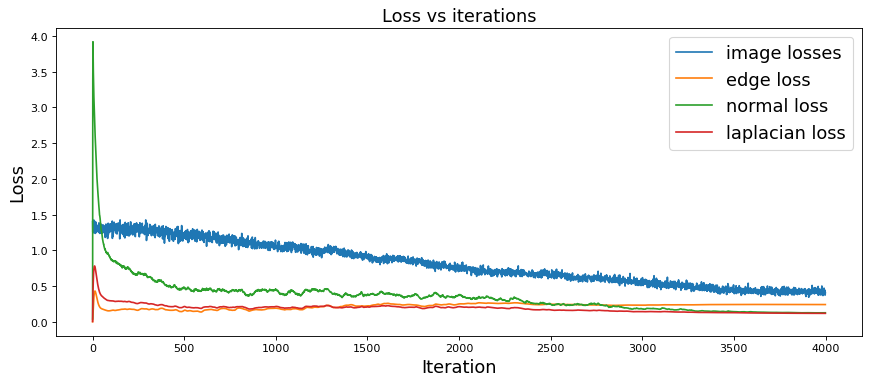

In [10]:
loss_image = loss_image

fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot([x*w_image for x in image_losses], label="image losses")
ax.plot([x*w_edge for x in edge_losses], label="edge loss")
ax.plot([x*w_normal for x in normal_losses], label="normal loss")
ax.plot([x*w_laplacian for x in laplacian_losses], label="laplacian loss")                                                                                                                                  
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")

/tmp/ipykernel_2033576/971355543.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


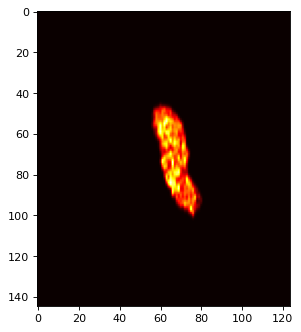

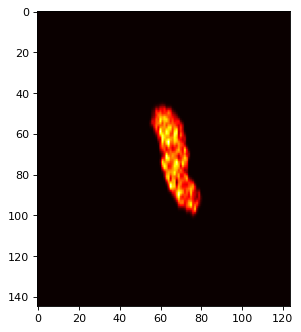

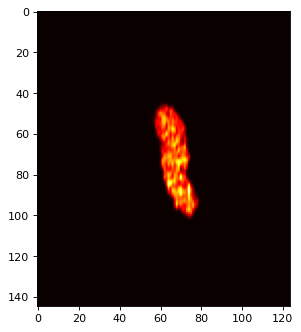

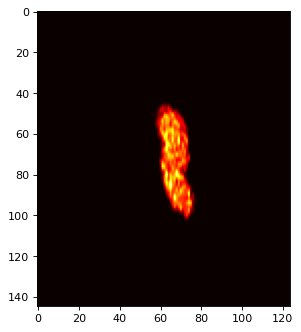

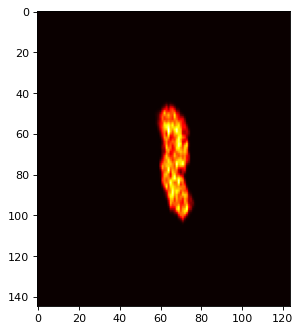

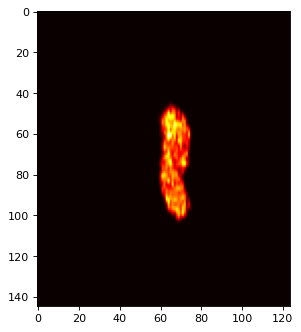

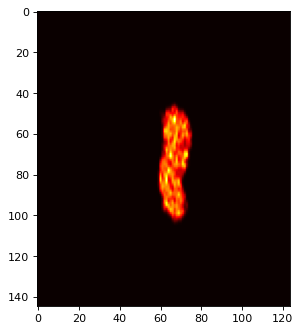

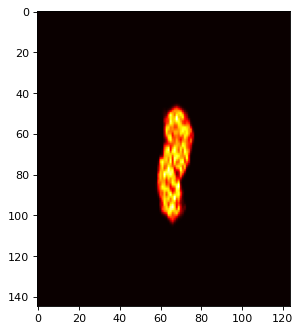

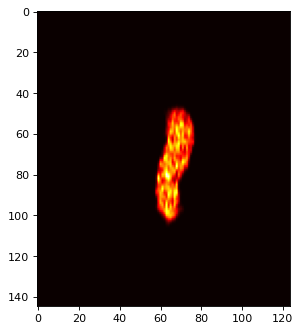

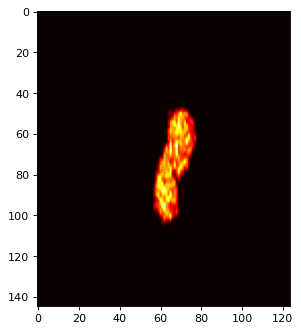

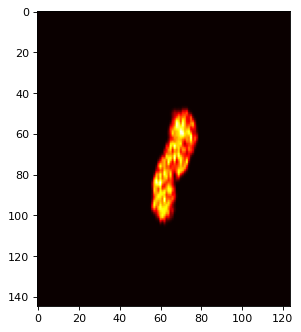

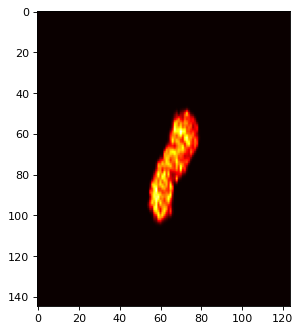

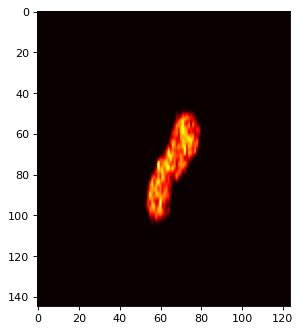

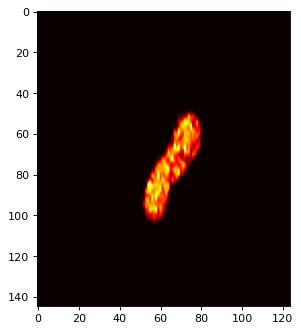

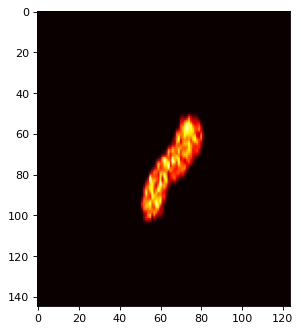

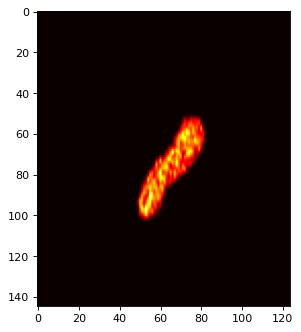

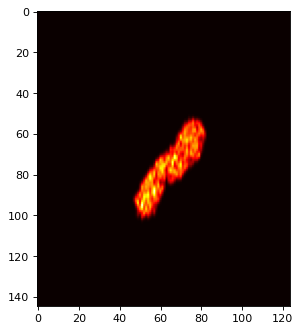

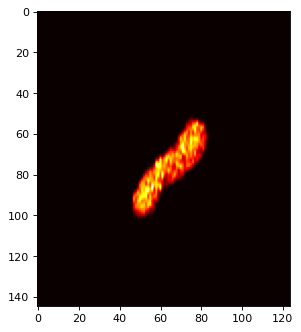

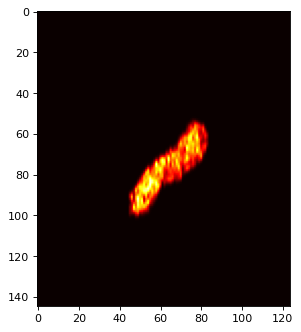

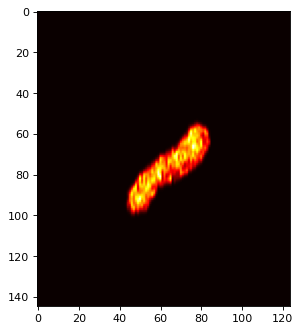

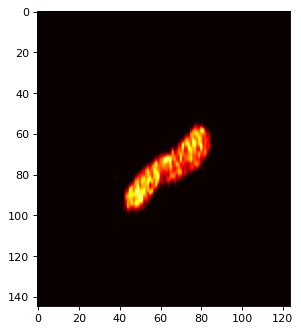

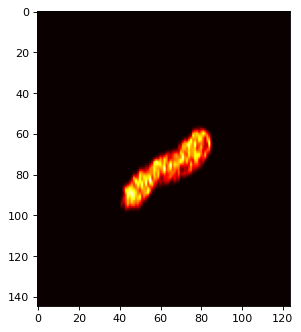

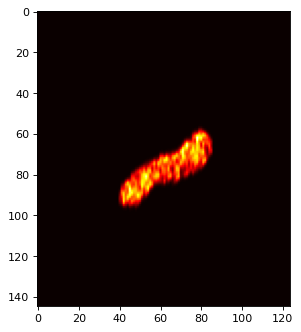

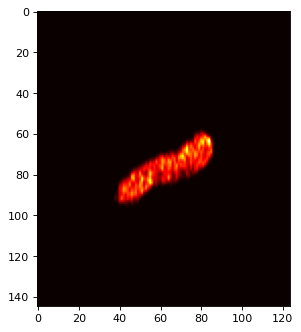

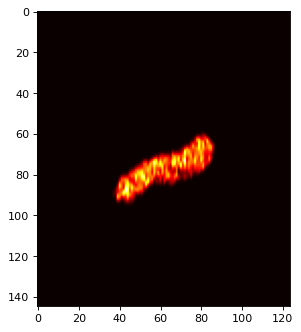

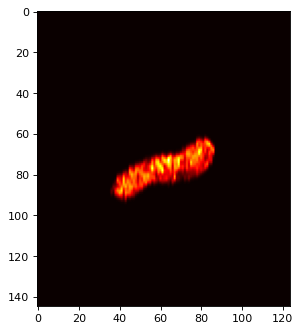

In [11]:
from torchvision import transforms
from PIL import Image
import os

image_src = ISAR_render1(new_src_mesh, Round_radar_los[0:6,:], SpinAxis, Omega)
# 取模归一化
image_src = torch.abs(image_src)
max1,_ = torch.max(image_src,dim=2)
max2,_ = torch.max(max1,dim=1)
image_src = image_src/max2.unsqueeze(1).unsqueeze(2)
plt.figure()
plt.imshow(image_src[0,:,:].detach().cpu(),cmap='hot')
for i in range(25):
    image_src = ISAR_render1(new_src_mesh, Round_radar_los[i:i+1,:], SpinAxis, Omega)
    image_src = torch.abs(image_src)
    max1,_ = torch.max(image_src,dim=2)
    max2,_ = torch.max(max1,dim=1)
    image_src = image_src/max2.unsqueeze(1).unsqueeze(2)
    image_save = image_src[0,:,:].detach().cpu()

    plt.figure()
    plt.imshow(image_save,cmap='hot')  

    array = image_save.squeeze(0).numpy() * 255  # 转换为数组并缩放到 0-255 范围
    array = array.astype('uint8')  # 将类型转换为 8 位整数

    # 创建一个 PIL 图片对象
    image = Image.fromarray(array, mode='L')  # 'L' 模式表示灰度图像

    # 确定保存路径
    output_folder = './point_inverse/result2'
    image_name = 'image' + str(i) + '.png'
    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, image_name)

    # 保存图片
    image.save(output_path)

/root/anaconda3/envs/3d_env/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


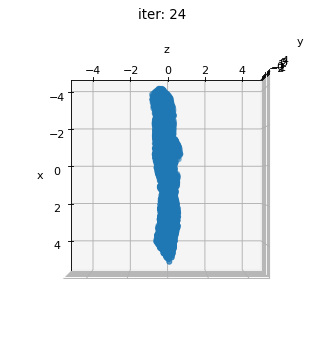

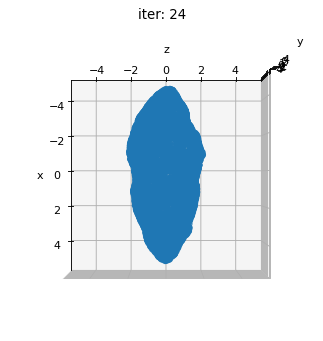

In [12]:
trg_obj = 'Geographos Radar-based, low-res(1).obj'
# 读取卫星各项参数
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale *5

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

plot_pointcloud(new_src_mesh, title="iter: %d" % i)
plot_pointcloud(trg_mesh, title="iter: %d" % i)

In [13]:
plot_batch_individually(trg_mesh)

In [14]:
plot_batch_individually(new_src_mesh)

In [15]:
plot_batch_individually(src_mesh)

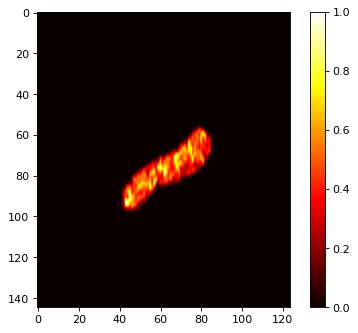

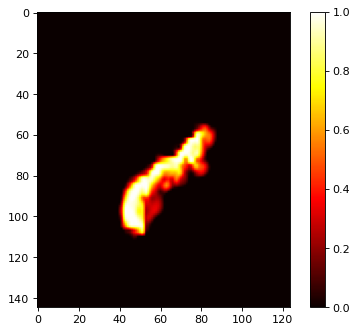

In [16]:
random_numbers = np.random.choice(range(0, 25), 6, replace=False)
image_src = ISAR_render1(new_src_mesh, Round_radar_los[random_numbers,:], SpinAxis, Omega)
image_trg_sample = image_trg[random_numbers,:,:]
image_src = torch.abs(image_src)
max1,_ = torch.max(image_src,dim=2)
max2,_ = torch.max(max1,dim=1)
image_src = image_src/max2.unsqueeze(1).unsqueeze(2)

plt.figure()
plt.imshow(image_src[0,:,:].detach().cpu(),cmap='hot')
plt.colorbar()
plt.figure()
plt.imshow(image_trg_sample[0,:,:].detach().cpu(),cmap='hot')
plt.colorbar()

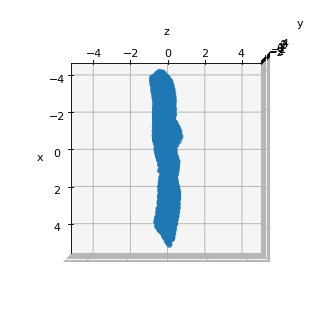

In [17]:
plot_pointcloud(new_src_mesh)

In [18]:
verts = new_src_mesh.verts_packed()
faces = new_src_mesh.faces_packed()

save_obj('/point_inverse/result2.obj', verts, faces)

FileNotFoundError: [Errno 2] No such file or directory: '/point_inverse/result2.obj'